In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import matplotlib.patches as mpatches

In [40]:
results_file = r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\IMU-compensatory-movement-detection\Data\Models\model_results_summary_refactored.csv"

In [41]:
results = pd.read_csv(results_file)

In [42]:
results.columns

Index(['window_size', 'task', 'model_name', 'best_params', 'f1_macro_mean',
       'f1_macro_lower', 'f1_macro_upper', 'accuracy_mean', 'accuracy_lower',
       'accuracy_upper', 'precision_macro_mean', 'precision_macro_lower',
       'precision_macro_upper', 'recall_macro_mean', 'recall_macro_lower',
       'recall_macro_upper', 'roc_auc_mean', 'roc_auc_lower', 'roc_auc_upper'],
      dtype='object')

In [43]:

# Your metrics
metrics = ['f1_macro_mean', 'accuracy_mean', 'precision_macro_mean', 'recall_macro_mean', 'roc_auc_mean']

# Keep only the columns we care about
results_small = results[['task', 'model_name', 'window_size', 'best_params'] + metrics].copy()

# ---------- SUMMARY DATAFRAME ----------

# One row per (task, model_name, window_size), metrics averaged over repeats
summary = (
    results_small
    .groupby(['task', 'model_name', 'window_size', 'best_params'], as_index=False)[metrics]
    .mean()
    .sort_values(['task', 'model_name', 'window_size'])
)

# If you want it globally sorted by window_size:
summary_by_window = summary.sort_values('window_size')

print(summary.head())
print(summary_by_window.head())



          task model_name window_size  \
0  cup-placing        KNN        1000   
1  cup-placing        KNN         250   
2  cup-placing        KNN         500   
3  cup-placing        KNN         750   
4  cup-placing        KNN       nowin   

                                best_params  f1_macro_mean  accuracy_mean  \
0  {'n_neighbors': 3, 'weights': 'uniform'}       0.619063       0.632251   
1  {'n_neighbors': 5, 'weights': 'uniform'}       0.587969       0.606077   
2  {'n_neighbors': 5, 'weights': 'uniform'}       0.552681       0.574503   
3  {'n_neighbors': 5, 'weights': 'uniform'}       0.573064       0.595324   
4  {'n_neighbors': 3, 'weights': 'uniform'}       0.511111       0.600000   

   precision_macro_mean  recall_macro_mean  roc_auc_mean  
0              0.687073           0.625224      0.780140  
1              0.651974           0.599031      0.778588  
2              0.610780           0.566057      0.768694  
3              0.646014           0.588772      0.8042

In [44]:
summary['best_params']

0               {'n_neighbors': 3, 'weights': 'uniform'}
1               {'n_neighbors': 5, 'weights': 'uniform'}
2               {'n_neighbors': 5, 'weights': 'uniform'}
3               {'n_neighbors': 5, 'weights': 'uniform'}
4               {'n_neighbors': 3, 'weights': 'uniform'}
                             ...                        
135    {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...
136    {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...
137    {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...
138    {'learning_rate': 0.01, 'max_depth': 3, 'n_est...
139    {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...
Name: best_params, Length: 140, dtype: object

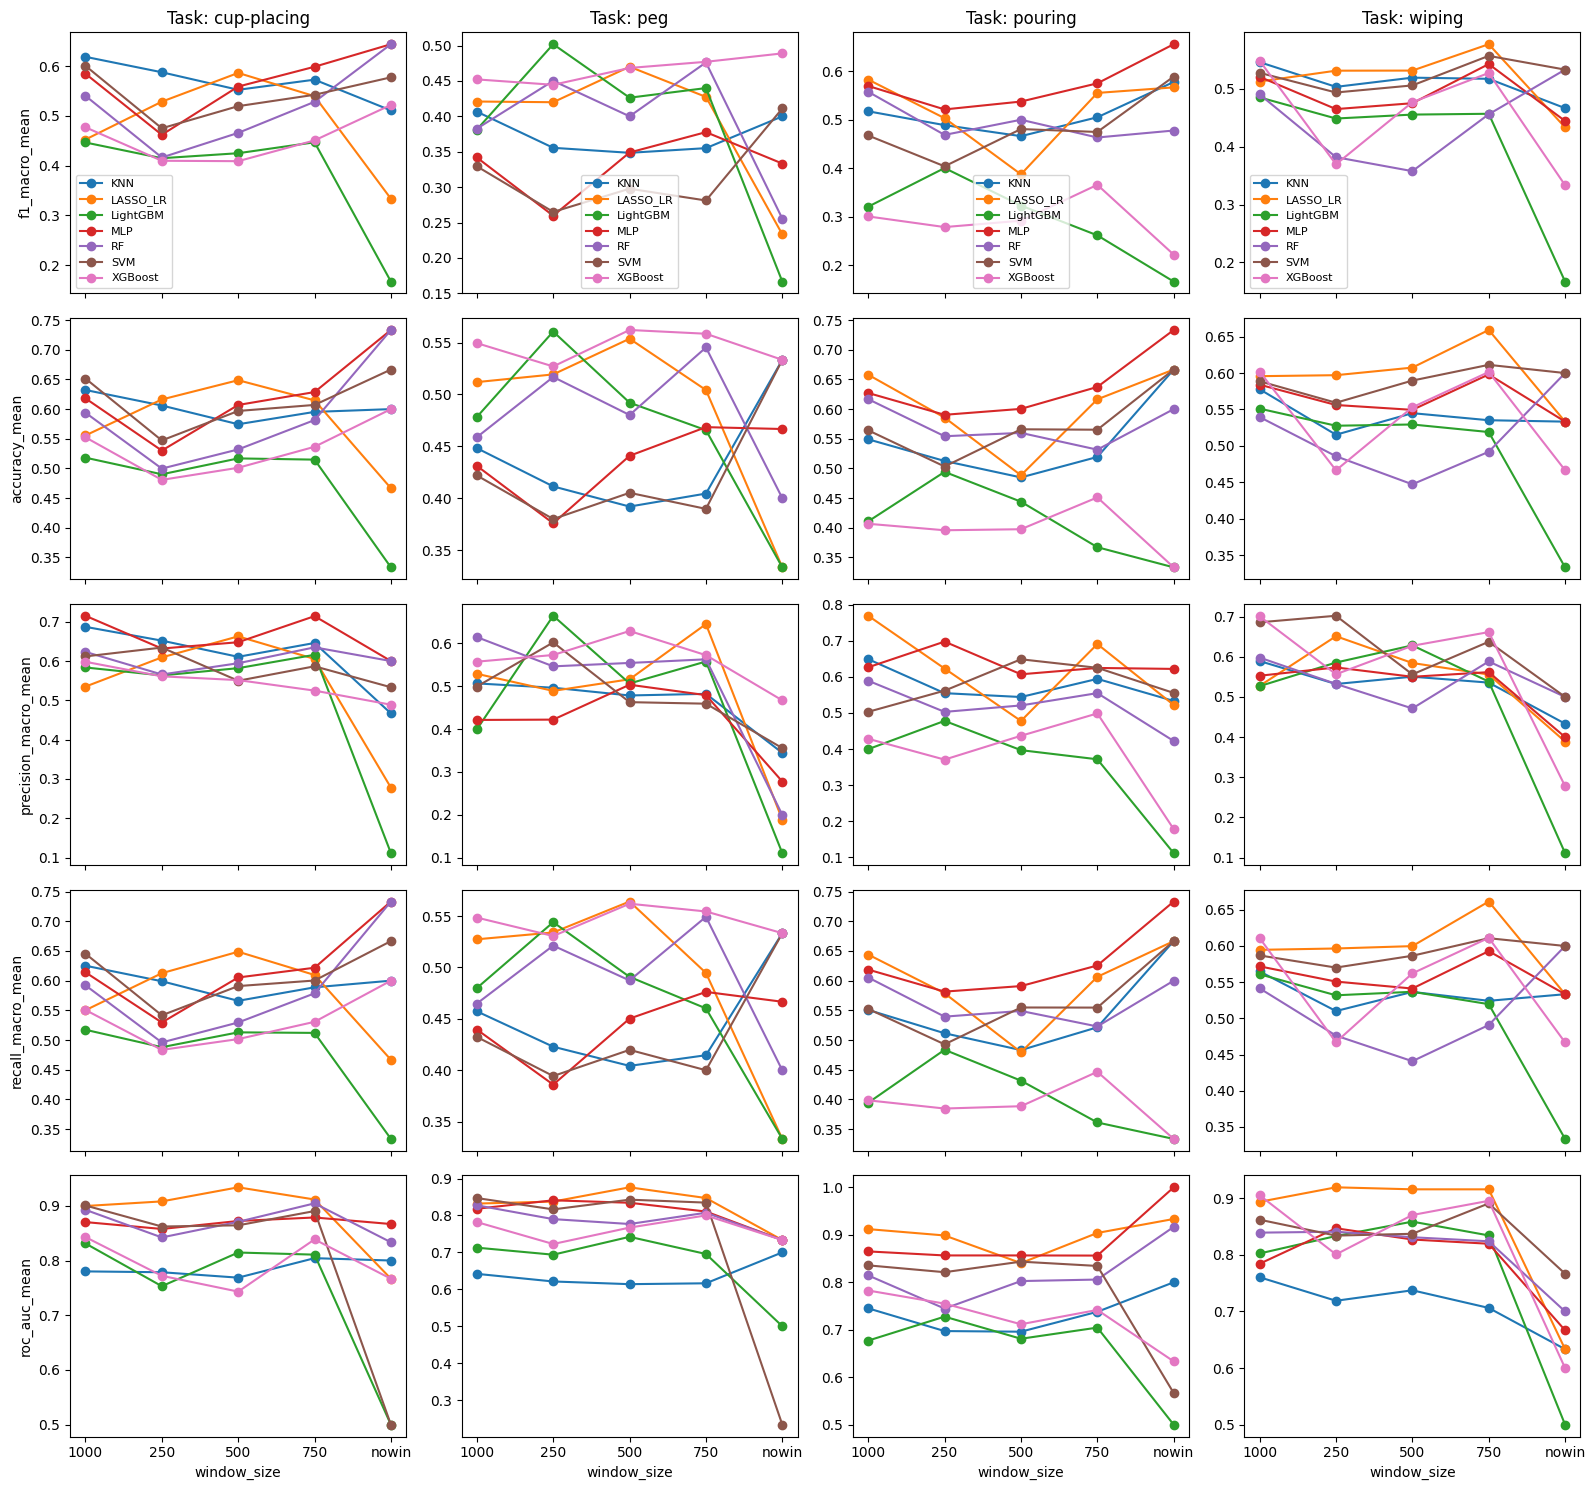

In [45]:
tasks = sorted(summary['task'].unique())
n_rows = len(metrics)      # 5 rows (one per metric)
n_cols = len(tasks)        # e.g. 4 tasks → 4 columns

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex='col'
)

# Make axes always 2D
if n_rows == 1 and n_cols == 1:
    axes = [[axes]]
elif n_rows == 1:
    axes = [axes]
elif n_cols == 1:
    axes = [[ax] for ax in axes]

for i, metric in enumerate(metrics):
    for j, task in enumerate(tasks):
        ax = axes[i][j]

        df_task = summary[summary['task'] == task]
        models = df_task['model_name'].unique()

        for model in models:
            df_tm = (
                df_task[df_task['model_name'] == model]
                .sort_values('window_size')
            )

            x = df_tm['window_size']
            y = df_tm[metric]

            ax.plot(x, y, marker='o', label=model)

        # Labels / titles
        if i == 0:
            ax.set_title(f"Task: {task}")
        if j == 0:
            ax.set_ylabel(metric)

        if i == n_rows - 1:
            ax.set_xlabel("window_size")

        # Legend only on the first row (one per column)
        if i == 0:
            ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [46]:
## Consider window of 1000 ms

In [47]:
# display per task
task_names = summary_by_window['task'].unique()
task_names

array(['cup-placing', 'peg', 'wiping', 'pouring'], dtype=object)

In [48]:

df_1000 = summary_by_window[summary_by_window['window_size'] == "750"]

for task_name in task_names:
    df_task = df_1000[df_1000["task"] == task_name]

    display(df_task.sort_values(by="f1_macro_mean"))

,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
13,cup-placing,LightGBM,750,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.447022,0.514884,0.615878,0.511994,0.810734
33,cup-placing,XGBoost,750,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.450854,0.536513,0.524782,0.530665,0.838603
23,cup-placing,RF,750,"{'max_depth': 10, 'n_estimators': 200}",0.528485,0.581542,0.634905,0.578642,0.904444
8,cup-placing,LASSO_LR,750,{'C': 10},0.539859,0.614722,0.605387,0.609590,0.911486
28,cup-placing,SVM,750,"{'C': 0.1, 'kernel': 'linear'}",0.542676,0.607045,0.586645,0.600253,0.890397
3,cup-placing,KNN,750,"{'n_neighbors': 5, 'weights': 'uniform'}",0.573064,0.595324,0.646014,0.588772,0.804298
18,cup-placing,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.599079,0.628723,0.714311,0.621782,0.878638


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
63,peg,SVM,750,"{'C': 0.1, 'kernel': 'linear'}",0.281206,0.389713,0.458966,0.400108,0.834773
38,peg,KNN,750,"{'n_neighbors': 3, 'weights': 'distance'}",0.355087,0.404460,0.481880,0.414714,0.616280
53,peg,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.377706,0.468458,0.478889,0.476240,0.810581
43,peg,LASSO_LR,750,{'C': 0.01},0.427445,0.504234,0.644206,0.494679,0.847172
48,peg,LightGBM,750,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.439923,0.465559,0.557144,0.460230,0.695664
58,peg,RF,750,"{'max_depth': None, 'n_estimators': 200}",0.476089,0.545258,0.562222,0.549242,0.807284
68,peg,XGBoost,750,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.477014,0.558471,0.571893,0.554437,0.800135


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
128,wiping,RF,750,"{'max_depth': None, 'n_estimators': 200}",0.456098,0.491964,0.588283,0.490764,0.823927
118,wiping,LightGBM,750,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.456946,0.519052,0.538145,0.519606,0.834286
108,wiping,KNN,750,"{'n_neighbors': 3, 'weights': 'uniform'}",0.517412,0.535262,0.535616,0.524240,0.706247
138,wiping,XGBoost,750,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.527520,0.601442,0.661354,0.611247,0.895400
123,wiping,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.542923,0.598090,0.561672,0.592880,0.819583
133,wiping,SVM,750,"{'C': 0.1, 'kernel': 'linear'}",0.557110,0.611278,0.637262,0.610740,0.890795
113,wiping,LASSO_LR,750,{'C': 0.1},0.577287,0.659108,0.555685,0.661426,0.915665


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
83,pouring,LightGBM,750,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.261901,0.367325,0.371530,0.361047,0.704520
103,pouring,XGBoost,750,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.365976,0.451205,0.498760,0.446434,0.741771
93,pouring,RF,750,"{'max_depth': None, 'n_estimators': 200}",0.463443,0.531675,0.555056,0.522847,0.805735
98,pouring,SVM,750,"{'C': 0.1, 'kernel': 'linear'}",0.474821,0.565289,0.625290,0.554633,0.834393
73,pouring,KNN,750,"{'n_neighbors': 5, 'weights': 'distance'}",0.505083,0.519388,0.594578,0.521456,0.737813
78,pouring,LASSO_LR,750,{'C': 1},0.555215,0.616500,0.691177,0.606475,0.903910
88,pouring,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.574977,0.637347,0.624894,0.625614,0.856235


In [49]:
df_task

,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
93,pouring,RF,750,"{'max_depth': None, 'n_estimators': 200}",0.463443,0.531675,0.555056,0.522847,0.805735
103,pouring,XGBoost,750,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.365976,0.451205,0.498760,0.446434,0.741771
98,pouring,SVM,750,"{'C': 0.1, 'kernel': 'linear'}",0.474821,0.565289,0.625290,0.554633,0.834393
83,pouring,LightGBM,750,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.261901,0.367325,0.371530,0.361047,0.704520
88,pouring,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.574977,0.637347,0.624894,0.625614,0.856235
73,pouring,KNN,750,"{'n_neighbors': 5, 'weights': 'distance'}",0.505083,0.519388,0.594578,0.521456,0.737813
78,pouring,LASSO_LR,750,{'C': 1},0.555215,0.616500,0.691177,0.606475,0.903910


In [50]:
# 4) Exclude the "all tasks" row(s)
df_1000_no_all = df_1000[df_1000['task'] != 'all tasks'].copy()

# 5) Average metrics across tasks per model
avg_across_tasks = (
    df_1000_no_all
    .groupby('model_name', as_index=False)[metrics]
    .mean()
    .sort_values('f1_macro_mean', ascending=False)   # sort by best f1_macro
)

display(avg_across_tasks)


,model_name,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
1,LASSO_LR,0.524952,0.598641,0.624114,0.593043,0.894558
3,MLP,0.523671,0.583155,0.594942,0.579129,0.841259
0,KNN,0.487662,0.513609,0.564522,0.512296,0.716159
4,RF,0.481028,0.537610,0.585117,0.535374,0.835347
5,SVM,0.463953,0.543331,0.577041,0.541433,0.862590
6,XGBoost,0.455341,0.536908,0.564197,0.535696,0.818978
2,LightGBM,0.401448,0.466705,0.520674,0.463219,0.761301


In [51]:
best_models = ["LASSO_LR", "MLP", "KNN"]

In [52]:

df_1000 = summary_by_window[summary_by_window['window_size'] == "750"]
df_1000_best = df_1000[df_1000["model_name"].isin(best_models)]

for task_name in task_names:
    df_task = df_1000_best[df_1000_best["task"] == task_name]

    display(df_task.sort_values(by="f1_macro_mean"))

,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
8,cup-placing,LASSO_LR,750,{'C': 10},0.539859,0.614722,0.605387,0.609590,0.911486
3,cup-placing,KNN,750,"{'n_neighbors': 5, 'weights': 'uniform'}",0.573064,0.595324,0.646014,0.588772,0.804298
18,cup-placing,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.599079,0.628723,0.714311,0.621782,0.878638


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
38,peg,KNN,750,"{'n_neighbors': 3, 'weights': 'distance'}",0.355087,0.404460,0.481880,0.414714,0.616280
53,peg,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.377706,0.468458,0.478889,0.476240,0.810581
43,peg,LASSO_LR,750,{'C': 0.01},0.427445,0.504234,0.644206,0.494679,0.847172


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
108,wiping,KNN,750,"{'n_neighbors': 3, 'weights': 'uniform'}",0.517412,0.535262,0.535616,0.524240,0.706247
123,wiping,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.542923,0.598090,0.561672,0.592880,0.819583
113,wiping,LASSO_LR,750,{'C': 0.1},0.577287,0.659108,0.555685,0.661426,0.915665


,task,model_name,window_size,best_params,f1_macro_mean,accuracy_mean,precision_macro_mean,recall_macro_mean,roc_auc_mean
73,pouring,KNN,750,"{'n_neighbors': 5, 'weights': 'distance'}",0.505083,0.519388,0.594578,0.521456,0.737813
78,pouring,LASSO_LR,750,{'C': 1},0.555215,0.616500,0.691177,0.606475,0.903910
88,pouring,MLP,750,"{'activation': 'relu', 'hidden_layer_sizes': [...",0.574977,0.637347,0.624894,0.625614,0.856235


In [53]:

metrics = ['f1_macro_mean', 'accuracy_mean', 'precision_macro_mean', 'recall_macro_mean', 'roc_auc_mean']

# 1) Start from summary_by_window and exclude "all tasks"
df_no_all = summary_by_window[summary_by_window['task'] != 'all tasks'].copy()

# 2) Exclude the "no window" rows BEFORE converting to int
#    (cover a few possible spellings just in case)
no_win_labels = ['no_win', 'nowin', 'No_win', 'NO_WIN']

df_no_all = df_no_all[~df_no_all['window_size'].isin(no_win_labels)]

# 3) Safely convert window_size to numeric ints
df_no_all['window_size'] = pd.to_numeric(df_no_all['window_size'], errors='coerce')
df_no_all = df_no_all.dropna(subset=['window_size'])
df_no_all['window_size'] = df_no_all['window_size'].astype(int)

# 4) Average metrics across tasks for each (model_name, window_size)
avg_tasks = (
    df_no_all
    .groupby(['model_name', 'window_size'], as_index=False)[metrics]
    .mean()
)

# Optional: std across tasks for error bars (accuracy & f1_macro)
std_tasks = (
    df_no_all
    .groupby(['model_name', 'window_size'], as_index=False)[['accuracy_mean', 'f1_macro_mean']]
    .std()
    .rename(columns={'accuracy_mean': 'accuracy_std', 'f1_macro_mean': 'f1_macro_std'})
)

avg_tasks = avg_tasks.merge(std_tasks, on=['model_name', 'window_size'], how='left')



In [54]:
# Font parameters (tweak as you like)
TITLE_FONTSIZE  = 16
LABEL_FONTSIZE  = 14
TICK_FONTSIZE   = 12
LEGEND_FONTSIZE = 12


models = avg_tasks['model_name'].unique()
window_sizes = sorted(avg_tasks['window_size'].unique())

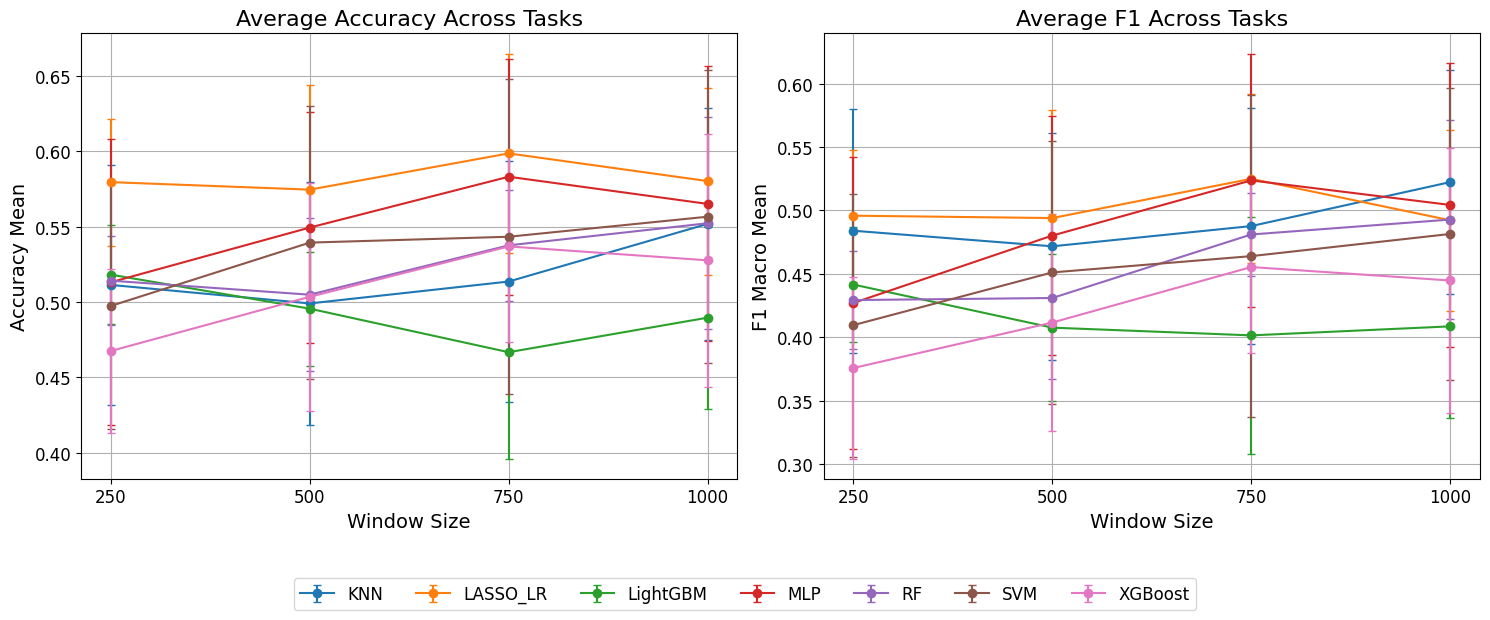

In [55]:


fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True)

# --- Left: Accuracy ---
for model in models:
    df_m = avg_tasks[avg_tasks['model_name'] == model].sort_values('window_size')
    axes[0].errorbar(
        df_m['window_size'],
        df_m['accuracy_mean'],
        yerr=df_m['accuracy_std'],
        marker='o',
        capsize=3,
        label=model
    )

axes[0].set_title("Average Accuracy Across Tasks", fontsize=TITLE_FONTSIZE)
axes[0].set_xlabel("Window Size", fontsize=LABEL_FONTSIZE)
axes[0].set_ylabel("Accuracy Mean", fontsize=LABEL_FONTSIZE)

# --- Right: F1 Macro ---
for model in models:
    df_m = avg_tasks[avg_tasks['model_name'] == model].sort_values('window_size')
    axes[1].errorbar(
        df_m['window_size'],
        df_m['f1_macro_mean'],
        yerr=df_m['f1_macro_std'],
        marker='o',
        capsize=3,
        label=model
    )

axes[1].set_title("Average F1 Across Tasks", fontsize=TITLE_FONTSIZE)
axes[1].set_xlabel("Window Size", fontsize=LABEL_FONTSIZE)
axes[1].set_ylabel("F1 Macro Mean", fontsize=LABEL_FONTSIZE)

# Common stuff for both axes
for ax in axes:
    ax.set_xticks([250, 500, 750, 1000])
    ax.grid()
    ax.tick_params(axis='both', labelsize=TICK_FONTSIZE)

# ---- Shared legend ----
# Grab handles & labels from one axis (they're the same across both)
handles, labels = axes[0].get_legend_handles_labels()

# Remove individual legends
for ax in axes:
    ax.legend().remove()

# Add one shared legend under the plots (or wherever you prefer)
fig.legend(
    handles,
    labels,
    loc='upper center',
    ncol=len(models),
    fontsize=LEGEND_FONTSIZE,
    bbox_to_anchor=(0.5, 0.04)  # adjust vertical position if needed
)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # leave space at bottom for legend
plt.show()



# Permutation - Importance Plots

Let’s start with permutation feature importance, because this is one of the simplest interpretability methods to explain. It’s a model interpretation technique that assigns an importance value for each feature. The importance is computed as how much the model performance would drop if we shuffle a feature. The more the performance drops (aka loss increases), the more important the feature was for correct predictions.

This technique is particularly useful for non-linear or opaque estimators, and involves randomly shuffling the values of a single feature and observing the resulting degradation of the model’s score. By breaking the relationship between the feature and the target, we determine how much the model relies on such particular feature.




In [56]:
# folder where you saved perm_* files
SAVE_DIR = r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\IMU-compensatory-movement-detection\Data\ModelsFinal"

In [ ]:


# ----------------- style params -----------------
TITLE_FONTSIZE  = 16
LABEL_FONTSIZE  = 14
TICK_FONTSIZE   = 11

N_COLS = 5
TOPK = 10
FIG_W, FIG_H = 15, 6

# ------------------------------------------------

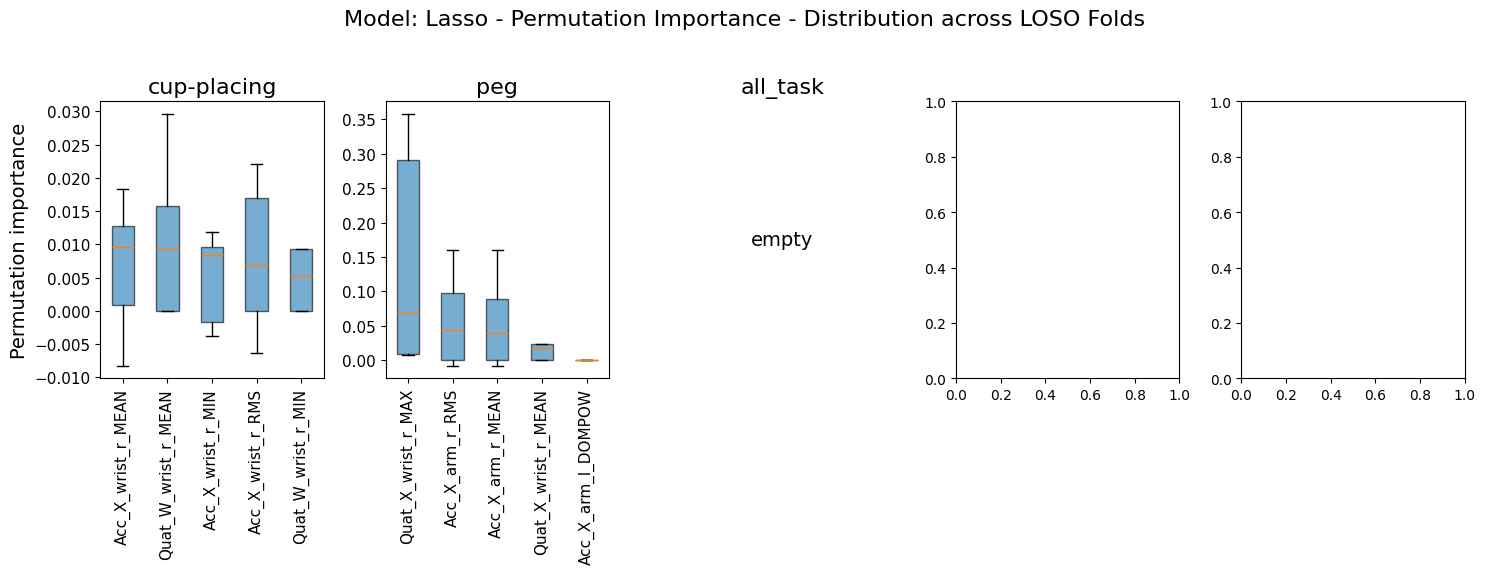

In [69]:


MODEL_NAME = "LASSO_LR"
name_for_title = 'Lasso'
TOPK = 5


# files: perm_{task}_{model}_test.csv
pattern = os.path.join(SAVE_DIR, f"perm_*_{MODEL_NAME}_test.csv")
files = sorted(glob.glob(pattern))
if len(files) == 0:
    raise FileNotFoundError(f"No files found with pattern: {pattern}")

df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

# tasks order + empty last panel
tasks = [t for t in df_all["task"].unique() if t != "all_task"]
tasks = tasks[:4] + ["all_task"]

fig, axes = plt.subplots(1, N_COLS, figsize=(FIG_W, FIG_H), sharey=False)

for ax, task_name in zip(axes, tasks):
    if task_name == "all_task":
        ax.set_title("all_task", fontsize=TITLE_FONTSIZE)
        ax.axis("off")
        ax.text(0.5, 0.5, "empty", ha="center", va="center",
                fontsize=LABEL_FONTSIZE, transform=ax.transAxes)
        continue

    df_t = df_all[df_all["task"] == task_name].copy()

    # robust top-K: median across subjects
    feat_rank = (
        df_t.groupby(["subject", "feature"])["perm_importance_mean"].mean()
            .reset_index()
            .groupby("feature")["perm_importance_mean"]
            .median()
            .sort_values(ascending=False)
    )
    top_feats = feat_rank.head(TOPK).index.tolist()

    # build data list (one array per feature across subjects)
    data_lists = []
    for feat in top_feats:
        vals = df_t[df_t["feature"] == feat]["perm_importance_mean"].values
        data_lists.append(vals)

    bp = ax.boxplot(
        data_lists,
        showfliers=False,
        patch_artist=True
    )

    # light styling (matplotlib default color)
    for patch in bp["boxes"]:
        patch.set_alpha(0.6)
        patch.set_linewidth(1.0)
    for element in ["whiskers", "caps", "medians"]:
        for line in bp[element]:
            line.set_linewidth(1.0)

    ax.set_title(task_name, fontsize=TITLE_FONTSIZE)
    #ax.set_xlabel("Feature", fontsize=LABEL_FONTSIZE)
    ax.tick_params(axis="y", labelsize=TICK_FONTSIZE)

    ax.set_xticks(np.arange(1, len(top_feats) + 1))
    ax.set_xticklabels(top_feats, rotation=90, fontsize=TICK_FONTSIZE)

axes[0].set_ylabel("Permutation importance", fontsize=LABEL_FONTSIZE)

plt.suptitle(f"Model: {name_for_title} - Permutation Importance - Distribution across LOSO Folds", fontsize=TITLE_FONTSIZE)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Shap Importance

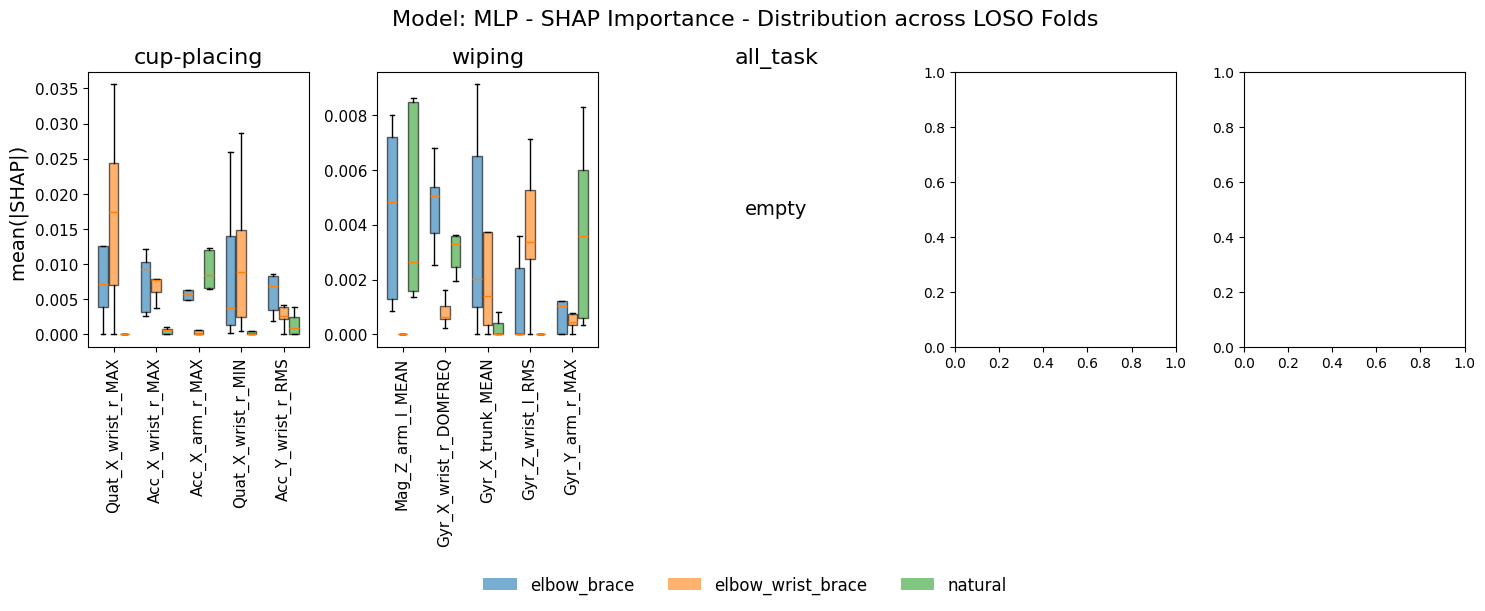

In [82]:
FIG_W, FIG_H = 15, 6

MODEL_NAME = "MLP"
name_for_title = "MLP"
TOPK = 5

# expected files: shap_{task}_{model}_test.csv
pattern = os.path.join(SAVE_DIR, f"shap_*_{MODEL_NAME}_test.csv")
files = sorted(glob.glob(pattern))
if len(files) == 0:
    raise FileNotFoundError(f"No files found with pattern: {pattern}")

df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

tasks = [t for t in df_all["task"].unique() if t != "all_task"]
tasks = tasks[:4] + ["all_task"]

cond_map = {0: "elbow_brace", 1: "elbow_wrist_brace", 2: "natural"}
df_all["condition"] = df_all["class"].map(cond_map)

# keep fixed order for conditions
cond_order = ["elbow_brace", "elbow_wrist_brace", "natural"]

# colors (matplotlib default cycle-ish)
cond_colors = {
    "elbow_brace": None,
    "elbow_wrist_brace": None,
    "natural": None,
}
# use default cycle automatically
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, c in enumerate(cond_order):
    cond_colors[c] = default_colors[i % len(default_colors)]

fig, axes = plt.subplots(1, N_COLS, figsize=(FIG_W, FIG_H), sharey=False)

for ax, task_name in zip(axes, tasks):
    if task_name == "all_task":
        ax.set_title("all_task", fontsize=TITLE_FONTSIZE)
        ax.axis("off")
        ax.text(0.5, 0.5, "empty", ha="center", va="center",
                fontsize=LABEL_FONTSIZE, transform=ax.transAxes)
        continue

    df_t = df_all[df_all["task"] == task_name].copy()

    # robust top-K: median across subjects of total SHAP across conditions
    feat_rank = (
        df_t.groupby(["subject", "feature"])["mean_abs_shap"].sum()
            .reset_index()
            .groupby("feature")["mean_abs_shap"]
            .median()
            .sort_values(ascending=False)
    )
    top_feats = feat_rank.head(TOPK).index.tolist()

    # --- build grouped boxplots: 3 boxes per feature ---
    n_feat = len(top_feats)
    n_cond = len(cond_order)

    base = np.arange(n_feat)  # feature centers at 0..n_feat-1
    group_width = 0.75        # total width occupied by the 3 boxes around each feature
    box_w = group_width / n_cond

    # positions for each condition within each feature group
    offsets = np.linspace(-group_width/2 + box_w/2, group_width/2 - box_w/2, n_cond)

    # collect data arrays per condition (list length n_feat)
    for ci, cond in enumerate(cond_order):
        data_lists = []
        for feat in top_feats:
            vals = df_t[(df_t["feature"] == feat) & (df_t["condition"] == cond)]["mean_abs_shap"].values
            data_lists.append(vals)

        pos = base + offsets[ci]

        bp = ax.boxplot(
            data_lists,
            positions=pos,
            widths=box_w * 0.9,
            patch_artist=True,
            showfliers=False,
            manage_ticks=False
        )

        # color styling
        for patch in bp["boxes"]:
            patch.set_facecolor(cond_colors[cond])
            patch.set_alpha(0.6)
            patch.set_linewidth(1.0)
        for element in ["whiskers", "caps", "medians"]:
            for line in bp[element]:
                line.set_linewidth(1.0)

    ax.set_title(task_name, fontsize=TITLE_FONTSIZE)
    ax.tick_params(axis="y", labelsize=TICK_FONTSIZE)

    # set x ticks at feature centers
    ax.set_xticks(base)
    ax.set_xticklabels(top_feats, rotation=90, fontsize=TICK_FONTSIZE)

axes[0].set_ylabel("mean(|SHAP|) ", fontsize=LABEL_FONTSIZE)

# ---- shared legend at the bottom ----
legend_patches = [mpatches.Patch(facecolor=cond_colors[c], alpha=0.6, label=c) for c in cond_order]
fig.legend(
    handles=legend_patches,
    loc="lower center",
    ncol=3,
    fontsize=LEGEND_FONTSIZE,
    frameon=False,
    bbox_to_anchor=(0.5, -0.02)
)

plt.suptitle(f"Model: {name_for_title} - SHAP Importance - Distribution across LOSO Folds", fontsize=TITLE_FONTSIZE)
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()


In [ ]:
# If you saved per-task/model mean_std metrics files:
#   metrics_{task}_{model}_mean_std.csv
# This loader will print mean±std for each task and model.

def print_task_metrics_from_mean_std(save_dir, model_names=("LASSO_LR", "MLP")):
    for model in model_names:
        files = [f for f in os.listdir(save_dir) if f.startswith("metrics_") and f.endswith(f"_{model}_mean_std.csv")]
        if not files:
            print(f"\n[WARN] No mean/std metric files found for {model} in {save_dir}")
            continue

        print(f"\n==== {model} (mean ± std across subjects) ====")
        for fn in sorted(files):
            dfm = pd.read_csv(os.path.join(save_dir, fn))
            task = dfm["task_"].iloc[0] if "task_" in dfm.columns else dfm["task"].iloc[0] if "task" in dfm.columns else fn

            # find metric columns automatically (expects ..._mean and ..._std)
            mean_cols = [c for c in dfm.columns if c.endswith("_mean")]
            std_cols  = [c for c in dfm.columns if c.endswith("_std")]

            # print compact line
            parts = []
            for mc in sorted(mean_cols):
                base = mc[:-5]  # strip _mean
                sc = base + "_std"
                mean_val = float(dfm[mc].iloc[0])
                std_val  = float(dfm[sc].iloc[0]) if sc in dfm.columns else float("nan")
                parts.append(f"{base}={mean_val:.2f}±{std_val:.2f}")

            print(f"- {task}: " + ", ".join(parts))

print_task_metrics_from_mean_std(SAVE_DIR, model_names=("LASSO_LR", "MLP"))


==== LASSO_LR (mean ± std across subjects) ====
- cup-placing: accuracy=0.61±0.17, f1_macro=0.54±0.21, precision_macro=0.66±0.23, recall_macro=0.60±0.17, roc_auc=0.91±0.07
- peg: accuracy=0.54±0.13, f1_macro=0.47±0.16, precision_macro=0.57±0.14, recall_macro=0.55±0.15, roc_auc=0.89±0.09

==== MLP (mean ± std across subjects) ====
- cup-placing: accuracy=0.61±0.12, f1_macro=0.58±0.13, precision_macro=0.69±0.09, recall_macro=0.61±0.13, roc_auc=0.87±0.06


# Global Model reuslts

In [ ]:
results_glob = pd.read_csv(r"C:\Users\giusy\OneDrive\Desktop\AI_Healtcare\IMU-compensatory-movement-detection\Data\Models\retrain_results_models.csv")

In [ ]:
results_glob

,f1_macro,accuracy,precision_macro,recall_macro,roc_auc,f1_macro_mean,f1_macro_lower,f1_macro_upper,accuracy_mean,accuracy_lower,...,recall_macro_lower,recall_macro_upper,roc_auc_mean,roc_auc_lower,roc_auc_upper,window_size,task,model_name,n_features,feature_subset
0,0.854515,0.853659,0.865708,0.852613,0.966790,0.854515,0.854515,0.854515,0.853659,0.853659,...,0.852613,0.852613,0.966790,0.966790,0.966790,1000,all_tasks,SVM,845,all
1,0.924101,0.924119,0.924188,0.924093,0.984783,0.924101,0.924101,0.924101,0.924119,0.924119,...,0.924093,0.924093,0.984783,0.984783,0.984783,1000,all_tasks,SVM,20,top_importance
2,0.875545,0.875339,0.875769,0.875619,0.963143,0.875545,0.875545,0.875545,0.875339,0.875339,...,0.875619,0.875619,0.963143,0.963143,0.963143,1000,all_tasks,MLP,845,all
3,0.653793,0.661247,0.654453,0.658746,0.832979,0.653793,0.653793,0.653793,0.661247,0.661247,...,0.658746,0.658746,0.832979,0.832979,0.832979,1000,all_tasks,MLP,20,top_importance
4,0.975821,0.975610,0.976163,0.975668,0.998607,0.975821,0.975821,0.975821,0.975610,0.975610,...,0.975668,0.975668,0.998607,0.998607,0.998607,1000,all_tasks,XGBoost,845,all
5,0.981258,0.981030,0.981570,0.981091,0.998817,0.981258,0.981258,0.981258,0.981030,0.981030,...,0.981091,0.981091,0.998817,0.998817,0.998817,1000,all_tasks,XGBoost,20,top_importance
6,0.932726,0.932249,0.938554,0.932740,0.983380,0.932726,0.932726,0.932726,0.932249,0.932249,...,0.932740,0.932740,0.983380,0.983380,0.983380,1000,all_tasks,LASSO_LR,845,all
7,0.904024,0.902439,0.913245,0.902720,0.967061,0.904024,0.904024,0.904024,0.902439,0.902439,...,0.902720,0.902720,0.967061,0.967061,0.967061,1000,all_tasks,LASSO_LR,20,top_importance


In [ ]:
results_glob[["f1_macro", "accuracy", "precision_macro", "recall_macro", "roc_auc", "model_name", "n_features"]]

,f1_macro,accuracy,precision_macro,recall_macro,roc_auc,model_name,n_features
0,0.854515,0.853659,0.865708,0.852613,0.966790,SVM,845
1,0.924101,0.924119,0.924188,0.924093,0.984783,SVM,20
2,0.875545,0.875339,0.875769,0.875619,0.963143,MLP,845
3,0.653793,0.661247,0.654453,0.658746,0.832979,MLP,20
4,0.975821,0.975610,0.976163,0.975668,0.998607,XGBoost,845
5,0.981258,0.981030,0.981570,0.981091,0.998817,XGBoost,20
6,0.932726,0.932249,0.938554,0.932740,0.983380,LASSO_LR,845
7,0.904024,0.902439,0.913245,0.902720,0.967061,LASSO_LR,20


If you use mean absolute SHAP per feature (the usual “global SHAP importance”):

It measures the average magnitude of that feature’s contribution to the model output across all evaluated samples.

Bigger value ⇒ that feature tends to move the prediction more (either toward compensatory or non-compensatory).

It does not tell you the direction by itself (because of the absolute value).
Direction comes from a beeswarm plot or from mean SHAP (signed), not mean |SHAP|.